In [1]:
from qiskit import *

In [3]:
nqbits = 3
circuit = QuantumCircuit(nqbits, nqbits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2],[0,1,2])

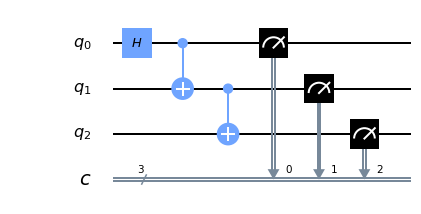

In [5]:
%matplotlib inline
circuit.draw(output='mpl')
#very similar to Hello World video. see that for this code

In [9]:
simulator = Aer.get_backend("qasm_simulator")
sim_result = execute(circuit, backend = simulator, shots = 1024).result()

In [10]:
from qiskit.visualization import plot_histogram

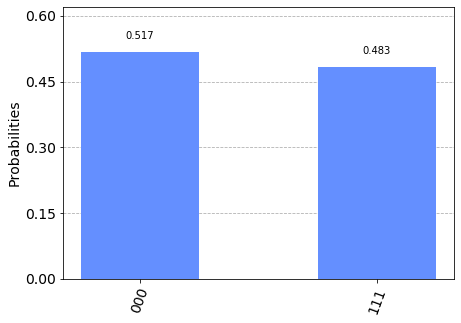

In [11]:
plot_histogram(sim_result.get_counts(circuit))
#this is what ideal results look like. about 50% each state

In [21]:
#now run on real qc
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')  #this device [ibmqx2] is called Yorktown device

Credentials are already in use. The existing account in the session will be replaced.


In [22]:
job = execute(circuit, backend = device, shots = 1024)   
print(job.job_id())  #good idea to see the id
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5e56aa3445520e0018ffb554
Job Status: job has successfully run


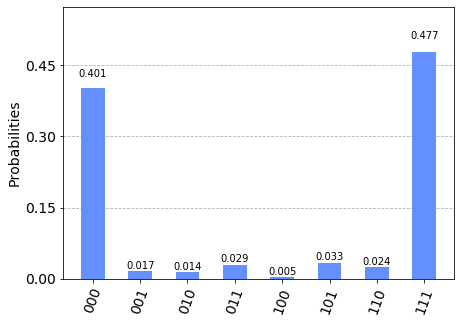

In [27]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [ ]:
#so iwth a real qc, have noise so get some shots in the mixed states 

In [ ]:
#[I surmise that the ignis package helps us squash some of this noise. How? who knows....]

In [28]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [25]:
help(complete_meas_cal)

Help on function complete_meas_cal in module qiskit.ignis.mitigation.measurement.circuits:

complete_meas_cal(qubit_list=None, qr=None, cr=None, circlabel='')
    Return a list of measurement calibration circuits for the full
    Hilbert space.
    
    Each of the 2**n circuits creates a basis state
    
    Args:
        qubit_list: A list of qubits to perform the measurement correction on,
        if None and qr is given then assumed to be performed over the entire
        qr. The calibration states will be labelled according to this ordering
    
        qr (QuantumRegister): A quantum register. If none one is created
    
        cr (ClassicalRegister): A classical register. If none one is created
    
        circlabel: A string to add to the front of circuit names for
        unique identification
    
    Returns:
        A list of QuantumCircuit objects containing the calibration circuits
    
        A list of calibration state labels
    
    Additional Information:
        

In [30]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

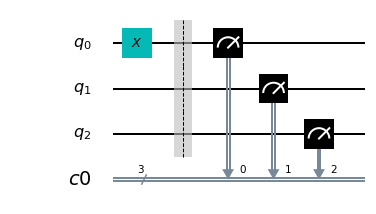

In [38]:
cal_circuits[1].draw(output='mpl')

In [32]:
len(cal_circuits)

8

In [39]:
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

5e594dd183ae0b00188263dd
Job Status: job has successfully run


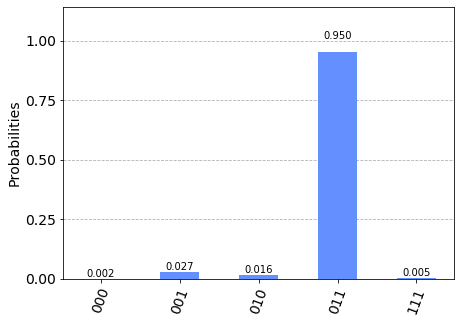

In [40]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))   #plotting just one of the circuits. randomly Abe picked 3

In [ ]:
#so the work flow in ignis is generate a series of circuits, run them on hardware, and teake results back
#and try to understand the results. so now create a fitter

In [41]:
help(CompleteMeasFitter)

Help on class CompleteMeasFitter in module qiskit.ignis.mitigation.measurement.fitters:

class CompleteMeasFitter(builtins.object)
 |  CompleteMeasFitter(results, state_labels, qubit_list=None, circlabel='')
 |  
 |  Measurement correction fitter for a full calibration
 |  
 |  Methods defined here:
 |  
 |  __init__(self, results, state_labels, qubit_list=None, circlabel='')
 |      Initialize a measurement calibration matrix from the results of running
 |      the circuits returned by `measurement_calibration_circuits`
 |      
 |      A wrapper for the tensored fitter
 |      
 |      Args:
 |          results: the results of running the measurement calibration
 |          circuits. If this is None the user will set a calibrarion matrix
 |          later
 |      
 |          state_labels: list of calibration state labels
 |          returned from `measurement_calibration_circuits`. The output matrix
 |          will obey this ordering.
 |      
 |          qubit_list: List of the qu

In [42]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)   #state labesl are what was generated

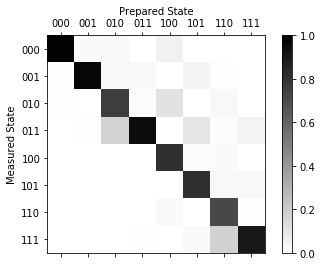

In [43]:
#if curioius can visualize the entire set of results. Legend on right
meas_fitter.plot_calibration()

In [ ]:
#diagnal is near prob one, light white coloar is near prob 0

In [44]:
#meas fitter extracts the parameters out of the calibrated results
#now create filter out of the fitter to filter noise

In [45]:
meas_filter = meas_fitter.filter

In [49]:
mitigated_result = meas_filter.apply(device_result)

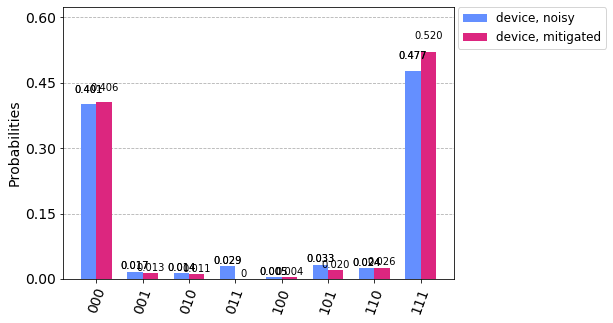

In [51]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

In [ ]:
#we have saved a filter. so we can build another circuit and apply that same filter and mitigate results

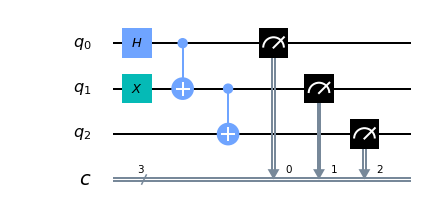

In [53]:
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2],[0,1,2])
circuit2.draw(output='mpl')

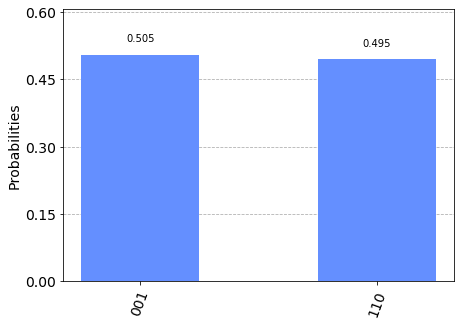

In [56]:
plot_histogram(execute(circuit2, backend = simulator, shots = 1024).result().get_counts(circuit2))

In [57]:
#now on real h/w

In [58]:
job2 = execute(circuit2, backend = device, shots = 1024)   
print(job2.job_id())  #good idea to see the id
job_monitor(job2)

5e5a7a780f7cd900195bf6e5
Job Status: job has successfully run


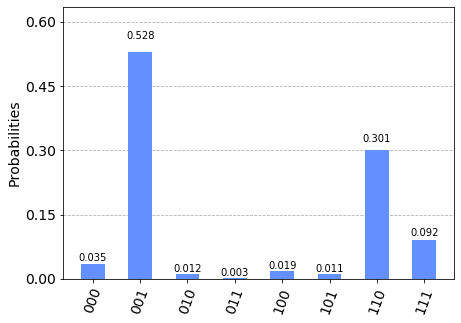

In [60]:
#NOPE, wrong code
device_result2 = job2.result()
plot_histogram(device_result2.get_counts(circuit2))

In [62]:
device_counts_2 = execute(circuit2, backend=device, shots=1024).result().get_counts(circuit2)

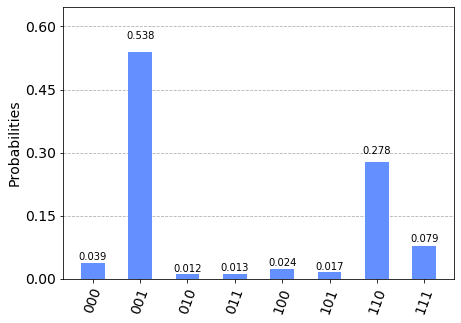

In [63]:
plot_histogram(device_counts_2)

In [64]:
#so now since we created our measurement filter already, can do

In [66]:
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

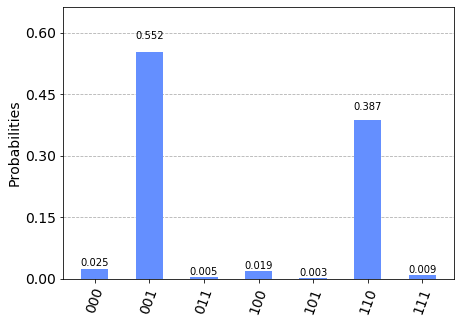

In [67]:
plot_histogram(device_mitigated_counts_2)

In [68]:
#in summary - we started by seeing how small errors result in measurement results far from ideal. 
#ignus helps us understand those errors.  Let's us set up parameters to generate a fitter 
#then to use fitter to generate a filter to let us mitigate errors in our measurement outcomes
#qiskit textbook has more detail/theory/math on "this procedure"

In [69]:
#EXTRA try to do 4 qubit circuit